In [1]:
import igraph
import copy
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import os
import glob
from helpers import *

%matplotlib inline

#why need download?
#3m resolution

#1. copublish use Ox' license 
#2. slider
#recurring problem - needs to look at construction sites
#
# Green info - little engine for 
# can we find another source?
# 

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
""" get all files """
files = glob.glob('./matrix_csvs/*')

g_MW_files = sorted([f for f in files if ((f.split('/')[-1].split('_')[1]=='green')and (f.split('/')[-1].split('_')[2]=='MW.csv') ) ])
b_MW_files =sorted([f for f in files if ((f.split('/')[-1].split('_')[1]=='blue') and (f.split('/')[-1].split('_')[2]=='MW.csv') )])
all_MW_files = sorted([f for f in files if ((f.split('/')[-1].split('_')[1]=='all') and (f.split('/')[-1].split('_')[2]=='MW.csv'))])

print all_MW_files

['./matrix_csvs/2004.75_all_MW.csv', './matrix_csvs/2007.75_all_MW.csv', './matrix_csvs/2008.75_all_MW.csv', './matrix_csvs/2009.75_all_MW.csv', './matrix_csvs/2010.75_all_MW.csv', './matrix_csvs/2011.5_all_MW.csv', './matrix_csvs/2012.75_all_MW.csv', './matrix_csvs/2013.75_all_MW.csv', './matrix_csvs/2014.75_all_MW.csv', './matrix_csvs/2015.0_all_MW.csv', './matrix_csvs/2015.25_all_MW.csv', './matrix_csvs/2015.5_all_MW.csv', './matrix_csvs/2015.75_all_MW.csv', './matrix_csvs/2016.0_all_MW.csv', './matrix_csvs/2016.25_all_MW.csv', './matrix_csvs/2016.5_all_MW.csv', './matrix_csvs/2016.75_all_MW.csv', './matrix_csvs/2017.0_all_MW.csv', './matrix_csvs/2017.25_all_MW.csv', './matrix_csvs/2017.5_all_MW.csv', './matrix_csvs/2017.75_all_MW.csv']


In [3]:
""" get a dict going with files and data """
data = {}
years = range(2007,2018)
years_m = [2007,2008,2009,2010,2012,2013,2014,2015,2016,2017]
for y in years_m:
    fname_all = [f for f in all_MW_files if ((str(y)+'.75') in f)][0]
    fname_g = [f for f in g_MW_files if ((str(y)+'.75') in f)][0]
    fname_b = [f for f in b_MW_files if ((str(y)+'.75') in f)][0]
    data[y]={'year':y,
             'fname_all':fname_all,
             'data_all':0.0,
             'fname_g':fname_g,
             'data_g':0.0,
             'fname_b':fname_b,
             'data_b':0.0}
    
data[2011]={'data_b': 0.0,
            'data_g': 0.0,
            'year': 2011,
            'fname_g': './matrix_csvs/2011.5_green_MW.csv',
            'fname_b': './matrix_csvs/2011.5_blue_MW.csv',
            'data_all': 0.0,
            'fname_all': './matrix_csvs/2011.5_all_MW.csv'}
    
print data[2016]['data_all']
print data

0.0
{2016: {'data_b': 0.0, 'data_g': 0.0, 'year': 2016, 'fname_g': './matrix_csvs/2016.75_green_MW.csv', 'fname_b': './matrix_csvs/2016.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2016.75_all_MW.csv'}, 2017: {'data_b': 0.0, 'data_g': 0.0, 'year': 2017, 'fname_g': './matrix_csvs/2017.75_green_MW.csv', 'fname_b': './matrix_csvs/2017.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2017.75_all_MW.csv'}, 2007: {'data_b': 0.0, 'data_g': 0.0, 'year': 2007, 'fname_g': './matrix_csvs/2007.75_green_MW.csv', 'fname_b': './matrix_csvs/2007.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2007.75_all_MW.csv'}, 2008: {'data_b': 0.0, 'data_g': 0.0, 'year': 2008, 'fname_g': './matrix_csvs/2008.75_green_MW.csv', 'fname_b': './matrix_csvs/2008.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2008.75_all_MW.csv'}, 2009: {'data_b': 0.0, 'data_g': 0.0, 'year': 2009, 'fname_g': './matrix_csvs/2009.75_green_MW.csv', 'fname_b': './matrix_csvs/2009.75_b

In [4]:
""" read in all the data """
for y in years:
    print y
    data[y]['data_all']=pd.read_csv(data[y]['fname_all'], encoding='utf-8').set_index('COMPANY')
    data[y]['data_g']=pd.read_csv(data[y]['fname_g'], encoding='utf-8').set_index('COMPANY')
    data[y]['data_b']=pd.read_csv(data[y]['fname_b'], encoding='utf-8').set_index('COMPANY')
    data[y]['data_ff'] = data[y]['data_all'].subtract(data[y]['data_g'], fill_value=0.0).subtract(data[y]['data_b'], fill_value=0.0)

2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [5]:
""" read in the countries """
country_df = pd.read_csv('country_iso_regions.csv', encoding='utf-8').set_index('country')

In [6]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def degree(x):
    #print x
    #print 'softmax: ', softmax(x)
    #raw_input('-->')
    return np.sum(softmax(x)/np.max(x))/x.shape[0]

In [7]:
#print data[2016]['data_ff']
regions = country_df.SIPS_REGION.unique()
print list(country_df)
print country_df.SIPS_REGION.unique()

sample_ff = data[2016]['data_ff'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
sample_g = data[2016]['data_g'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
sample_b = data[2016]['data_b'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
sample_all = data[2016]['data_all'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T



print sample_ff.shape
print sample_g[sample_all['AFRICA']>0][['AFRICA']]/sample_all[sample_all['AFRICA']>0][['AFRICA']]
#print sample_b.shape
#print sample_all.shape
#print sample_all[sample_all['AFRICA']>0].shape
#print sample_g[sample_all['AFRICA']>0].shape
#print sample_g.T.sum()/sample_all.T.sum()

print clamp(16)

['Unnamed: 0', u'iso2', u'iso3', u'iso_num', u'region', u'region_IEA', u'region_IEA_secondary', u'region_IEA_final', u'SIPS_REGION', u'urban_pop', u'rural_pop', u'population', u'portion']
[u'OTHERX' u'TE' u'AFRICA' u'LAM' u'OECD_PAC' u'OECD_EUR' u'ME' u'OECD_AMX'
 u'CN' u'IN' u'US']
(34618, 11)
SIPS_REGION                       AFRICA
ESKOM                           0.002407
SOC ALGERIENNE ELEC (SONELGAZ)  0.000000
GENERAL ELECTRICITY CO LIBYA    0.124224
CAIRO ELEC PROD CO (CEPC)       0.164175
EAST DELTA ELECTRICITY PROD CO  0.100205
MIDDLE DELTA ELEC PROD CO       0.306921
WEST DELTA ELEC PRODUCTION CO   0.061237
OFF NATL L'ELEC L'EAU (ONEE)    0.076054
SOC TUNISIENNE ELEC GAZ (STEG)  0.073992
ETHIOPIAN ELECTRIC POWER CORP   0.031370
UPPER EGYPT ELEC PRODUCTION CO  0.124564
ACWA POWER DEVELOPMENT          1.000000
HYDRO PLANTS ELEC PROD CO       0.000000
GLOBAL POWER GENERATION         0.000000
EDF ENERGIES NOUVELLES          0.905213
NIGER DELTA POWER HOLDING CO    0.000000
SOC ALG

In [8]:
def str_col(g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(int(g)), clamp(int(b)))

2007
                                      all       cumsum           bin
COMPANY                                                             
WHEELERSBURG ELEMENTARY          0.000001     0.000001  2.322037e-08
COMUNE DI ARGENTA                0.000001     0.000002  4.644074e-08
KANTEI - PM'S RESIDENCE          0.000001     0.000003  6.966111e-08
VILLAGE DE BETANIA               0.000001     0.000004  9.288148e-08
HOWARD INDUSTRIES OH             0.000001     0.000005  1.161018e-07
BEECHWOOD FARMS PRES             0.000001     0.000006  1.393222e-07
CURTIS E                         0.000001     0.000007  1.625426e-07
MIE UNIVERSITY                   0.000001     0.000008  1.857630e-07
SIEBERT R                        0.000001     0.000009  2.089833e-07
TERRY GRAY                       0.000001     0.000010  2.322037e-07
TOYOHASHI SOZO UNIVERSITY        0.000002     0.000012  2.786444e-07
COMMUNITY ENVIRON COUNCIL        0.000002     0.000014  3.250852e-07
LAMBETH YOUTH CENTER         

                                      all       cumsum           bin
COMPANY                                                             
WHEELERSBURG ELEMENTARY          0.000001     0.000001  2.210989e-08
TERRY GRAY                       0.000001     0.000002  4.421978e-08
CURTIS E                         0.000001     0.000003  6.632967e-08
COMUNE DI ARGENTA                0.000001     0.000004  8.843956e-08
BEECHWOOD FARMS PRES             0.000001     0.000005  1.105495e-07
VILLAGE DE BETANIA               0.000001     0.000006  1.326593e-07
HOWARD INDUSTRIES OH             0.000001     0.000007  1.547692e-07
MIE UNIVERSITY                   0.000001     0.000008  1.768791e-07
KANTEI - PM'S RESIDENCE          0.000001     0.000009  1.989890e-07
SIEBERT R                        0.000001     0.000010  2.210989e-07
TOYOHASHI SOZO UNIVERSITY        0.000002     0.000012  2.653187e-07
ASPEN MOUNTAIN SKI RESORT        0.000002     0.000014  3.095385e-07
UNION OF CONCERNED SCIENTISTS    0

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    47.318019    47.318019  84.965863   54.454413  17351  #005436    4.540355
1    47.286068    94.604087  72.341333   41.303157   1837  #004829    3.565139
2    47.355124   141.959211  62.798046   42.477915    907  #003e2a    3.258637
3    47.290479   189.249690  54.316993   43.751947    536  #00362b    3.030195
4    47.283002   236.532691  45.891293   42.112636    371  #002d2a    2.870404
5    47.213560   283.746251  52.172626   32.396168    269  #003420    2.730782
6    47.369107   331.115358  54.525882   41.128063    206  #003629    2.614897
7    47.416571   378.531929  43.910437   38.113711    168  #002b26    2.526339
8    47.139864   425.671793  41.509386   39.783527    136  #002927    2.434569
9    47.490497   473.162290  31.128404   56.238088    114  #001f38    2.357935
10   47.298253   520.460543  38.429406   49.141516  

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    49.754423    49.754423  86.823857   55.903424  18273  #005637    4.562840
1    49.769150    99.523573  76.519453   43.182864   1929  #004c2b    3.586362
2    49.744686   149.268259  65.282800   43.636807    951  #00412b    3.279211
3    49.704355   198.972614  58.740327   46.516562    561  #003a2e    3.049993
4    49.771944   248.744558  50.099031   43.461768    388  #00322b    2.889862
5    49.715489   298.460047  63.493946   37.882113    279  #003f25    2.746634
6    49.634909   348.094956  57.758108   41.459082    213  #003929    2.629410
7    49.733208   397.828163  45.795470   42.919972    174  #002d2a    2.541579
8    49.827101   447.655264  47.595325   36.754933    144  #002f24    2.459392
9    49.685529   497.340793  29.303127   47.462004    119  #001d2f    2.376577
10   49.728176   547.068969  39.555043   44.584128  

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    51.158515    51.158515  89.317483   55.523913  18807  #005937    4.575350
1    51.146911   102.305426  78.287951   44.432164   2029  #004e2c    3.608312
2    51.153550   153.458976  71.032874   44.468480   1011  #00472c    3.305781
3    51.136896   204.595872  61.548580   45.856280    607  #003d2d    3.084219
4    51.059316   255.655188  55.234667   49.649542    418  #003731    2.922206
5    51.110158   306.765346  65.518122   36.831999    304  #004124    2.783904
6    51.211875   357.977221  61.909657   38.213453    230  #003d26    2.662758
7    51.183708   409.160929  50.156857   38.367199    186  #003226    2.570543
8    50.963618   460.124547  50.649433   43.982903    154  #00322b    2.488551
9    51.351870   511.476417  36.087311   43.342183    127  #00242b    2.404834
10   51.008513   562.484930  38.998426   57.736231  

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    53.055124    53.055124  92.457838   56.133661  20014  #005c38    4.602364
1    53.063384   106.118508  81.250563   47.132972   2226  #00512f    3.648555
2    53.031486   159.149994  76.484706   41.926468   1102  #004c29    3.343212
3    53.068418   212.218412  68.231273   45.537363    664  #00442d    3.123198
4    53.019312   265.237724  58.931128   48.902846    456  #003a30    2.959995
5    53.102052   318.339776  67.433123   37.874020    333  #004325    2.823474
6    52.980121   371.319897  61.692051   42.363295    253  #003d2a    2.704151
7    53.011847   424.331744  61.638060   34.311574    203  #003d22    2.608526
8    52.971172   477.302915  58.892092   42.867695    170  #003a2a    2.531479
9    52.919232   530.222147  48.595555   50.524967    141  #003032    2.450249
10   53.234864   583.457011  46.221748   53.963422  

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    54.844004    54.844004  93.734489   59.786600  21139  #005d3b    4.626114
1    54.848947   109.692951  84.840077   49.953959   2397  #005431    3.680698
2    54.822700   164.515651  78.874342   46.982195   1187  #004e2e    3.375481
3    54.831491   219.347142  72.897449   45.035667    724  #00482d    3.160769
4    54.796040   274.143182  62.620182   47.278633    488  #003e2f    2.989450
5    54.813288   328.956470  73.042858   37.382826    359  #004925    2.856124
6    54.854672   383.811141  69.567807   51.998067    274  #004533    2.738781
7    54.869905   438.681047  66.484730   34.344861    218  #004222    2.639486
8    54.950142   493.631189  50.785415   45.092622    182  #00322d    2.561101
9    54.826001   548.457190  67.249418   45.234482    153  #00432d    2.485721
10   54.536120   602.993310  50.004414   38.190551  

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    56.812755    56.812755  94.280421   61.531393  22231  #005e3d    4.647989
1    56.812291   113.625046  86.682783   53.695781   2552  #005635    3.707911
2    56.792158   170.417204  82.728516   47.588645   1257  #00522f    3.400365
3    56.778968   227.196172  72.705119   52.704622    777  #004834    3.191451
4    56.849761   284.045933  65.911362   50.004913    522  #004132    3.018700
5    56.751876   340.797809  70.706624   46.491092    382  #00462e    2.883093
6    56.765899   397.563708  71.923258   49.417140    291  #004731    2.764923
7    56.687700   454.251408  78.627366   38.787902    232  #004e26    2.666518
8    56.831691   511.083099  52.675882   40.579177    194  #003428    2.588832
9    56.955400   568.038499  67.073578   54.520071    163  #004336    2.513218
10   56.565749   624.604248  64.066566   32.184215  

            all       cumsum          g           b  count    color  \
bin                                                                   
0     58.614278    58.614278  94.367621   63.021273  23229  #005e3f   
1     58.592346   117.206624  90.531160   53.645745   2691  #005a35   
2     58.646048   175.852672  88.555747   47.702950   1327  #00582f   
3     58.595410   234.448082  79.086837   52.132386    826  #004f34   
4     58.568640   293.016722  77.875997   49.282392    554  #004d31   
5     58.690329   351.707051  74.017382   43.270662    409  #004a2b   
6     58.442978   410.150029  80.511143   41.957212    311  #005029   
7     58.694474   468.844503  79.695146   40.426154    250  #004f28   
8     58.432652   527.277155  58.350428   38.510873    206  #003a26   
9     58.612476   585.889631  77.657036   45.539687    176  #004d2d   
10    58.832927   644.722558  65.806646   39.929620    150  #004127   
11    58.316025   703.038583  65.601163   49.711162    129  #004131   
12    

           all       cumsum          g           b  count    color  log10count
bin                                                                           
0    60.341638    60.341638  95.514224   63.472746  24032  #005f3f    4.681820
1    60.348010   120.689648  96.034341   51.903478   2870  #006033    3.758912
2    60.340100   181.029748  92.698404   49.113970   1417  #005c31    3.452400
3    60.329410   241.359158  88.457768   48.320484    889  #005830    3.249932
4    60.280265   301.639423  85.412645   47.144546    599  #00552f    3.078457
5    60.418089   362.057512  75.356160   46.351349    445  #004b2e    2.949390
6    60.182848   422.240360  82.539716   44.751165    335  #00522c    2.826075
7    60.364979   482.605339  96.104233   35.825416    267  #006023    2.727541
8    60.417862   543.023201  67.124160   34.995915    221  #004322    2.645422
9    60.154793   603.177994  80.756854   37.740848    188  #005025    2.575188
10   60.438908   663.616902  70.668784   48.156040  

           all       cumsum           g           b  count    color  \
bin                                                                   
0    61.869296    61.869296   96.344500   65.100919  24748  #006041   
1    61.854309   123.723605  100.241166   51.176593   2980  #006433   
2    61.898932   185.622537   94.802358   48.421372   1471  #005e30   
3    61.821857   247.444394   92.098326   47.667064    928  #005c2f   
4    61.895087   309.339481   86.111583   46.393088    623  #00562e   
5    61.880264   371.219745   80.257390   45.238059    460  #00502d   
6    61.785716   433.005461   88.076369   45.912869    347  #00582d   
7    61.784444   494.789905  101.865069   35.427203    278  #006523   
8    62.005953   556.795858   75.957530   38.500680    232  #004b26   
9    61.907879   618.703737   74.954866   40.315574    196  #004a28   
10   61.885537   680.589274   78.204257   44.721133    165  #004e2c   
11   61.499590   742.088864   68.163773   40.531826    143  #004428   
12   6

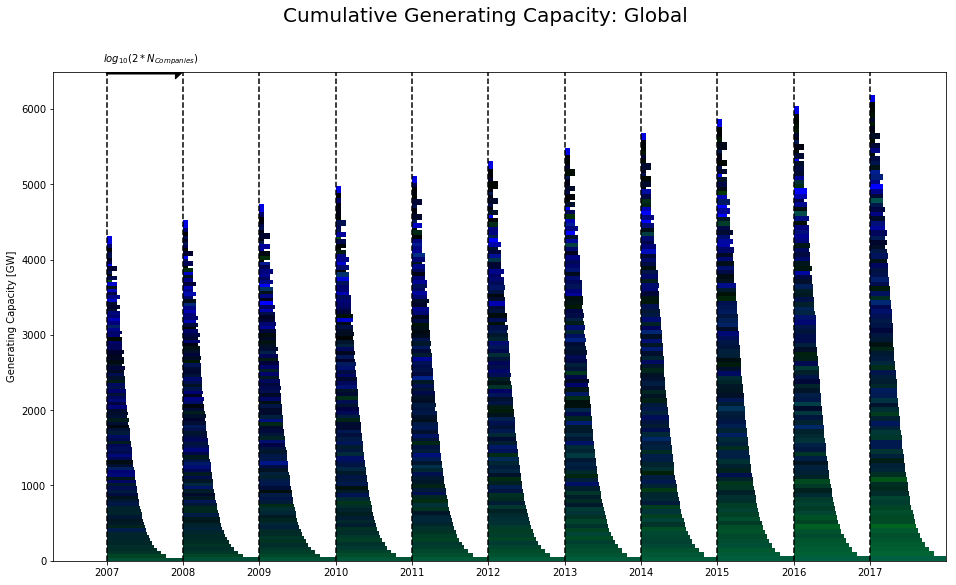

In [38]:
""" let's plot em all """
import matplotlib.patches as mpatches
import matplotlib.lines as mlines



f, axarr = plt.subplots(1, figsize=(16,9))
axarr.set_xlim(2006.3,2018)
axarr.set_xticks(years)
    
for y in years:
        
    print y
        
    sample_ff = data[y]['data_ff'].T.sum().T
    #print sample_ff
    sample_g = data[y]['data_g'].T.sum().T
    sample_b = data[y]['data_b'].T.sum().T
    sample_all = data[y]['data_all'].T.sum().T

    #"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b))
    pos = pd.DataFrame(sample_all, columns=['all'])
    #print list(pos)
    #g = sample_g[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
    #b = sample_b[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        
    pos = pos.sort_values('all',ascending=True)/1000.0
    pos['cumsum'] = pos.cumsum()
    pos['bin']=(pos['cumsum']/pos['cumsum'].max()*100)#.astype(int)
    print pos
    pos = pos.dropna()
    pos['bin'] = pos['bin'].astype(int)

        
    #pos = pos.sort_values('cumsum', ascending=False)

    pos['g'] = sample_g[sample_all>0]/sample_all[sample_all>0]*255.0
    pos['b'] = sample_b[sample_all>0]/sample_all[sample_all>0]*255.0
    
    pos['color'] = pos.apply(lambda row: str_col(row['g'], row['b']), axis=1)
    #print pos
        
    down_sample = pos.groupby('bin').sum()

    down_sample['count'] = pos.groupby('bin').count()['all']

    down_sample.g = down_sample.g/down_sample['count']
    down_sample.b = down_sample.b/down_sample['count']

    down_sample['cumsum']=down_sample['all'].cumsum()
    down_sample['color']=down_sample.apply(lambda row: str_col(row['g'], row['b']), axis=1)
    down_sample['log10count'] = np.log10(down_sample['count'])+np.log10(2.0)
    print down_sample
        
        
    axarr.axvline(x=y, color='k', linestyle='--')
    """
    axarr.barh(pos['cumsum'].values-pos[r].values, #position
                   (1.0-pos['cumsum'].values/(pos['cumsum'].max())*0.9), #width
                   pos[r].values, #height
                   y,
                   align='edge',
                   color=pos.color.values)
    """
    #print down_sample['log10count'].max()
    axarr.barh(down_sample['cumsum'].values-down_sample['all'].values, #position
                   down_sample['log10count']/4.5, #down_sample['log10count'].max(),#(1.0-down_sample['cumsum'].values/(down_sample['cumsum'].max())*0.9), #width
                   down_sample['all'].values, #height
                   y,
                   align='edge',
                   color=down_sample.color.values)
        
        
    #ariel deranger
    #raw_input('-->')
    #print pos
axarr.set_ylabel('Generating Capacity [GW]')
axarr.set_ylim(bottom=0.0)
    
bottom,top = axarr.get_ylim()
    
axarr.arrow(2007, top, .9, 0, head_width=(top-bottom)*0.03, head_length=0.1, fc='k', ec='k', width=(top-bottom)*0.01)

axarr.text(2006.95, top+(top-bottom)*0.02,'$log_{10}(2*N_{Companies}$)')
    
green_patch = mpatches.Patch(color='green', label='green data')
blue_patch = mpatches.Patch(color='blue', label='blue data')
black_patch = mpatches.Patch(color='black', label='black data')
    
f.legend((black_patch,blue_patch,green_patch), ('Fossil Fuels','Nuclear & Large-Scale Hydro','Renewables'), loc='center', bbox_to_anchor=(0.5,0.92), ncol=3)

f.suptitle('Cumulative Generating Capacity: Global', fontsize=20)
f.savefig('./figures/1_'+'global'+'.png')
plt.show()
        

OTHERX
2007
3.22582599146
2008
3.24501887074
2009
3.26764098235
2010
3.29269900304
2011
3.3049211619
2012
3.3467440546
2013
3.3602146133
2014
3.38165648259
2015
3.40483371662
2016
3.41962536089
2017
3.43200668727


AttributeError: 'numpy.ndarray' object has no attribute 'get_ylim'

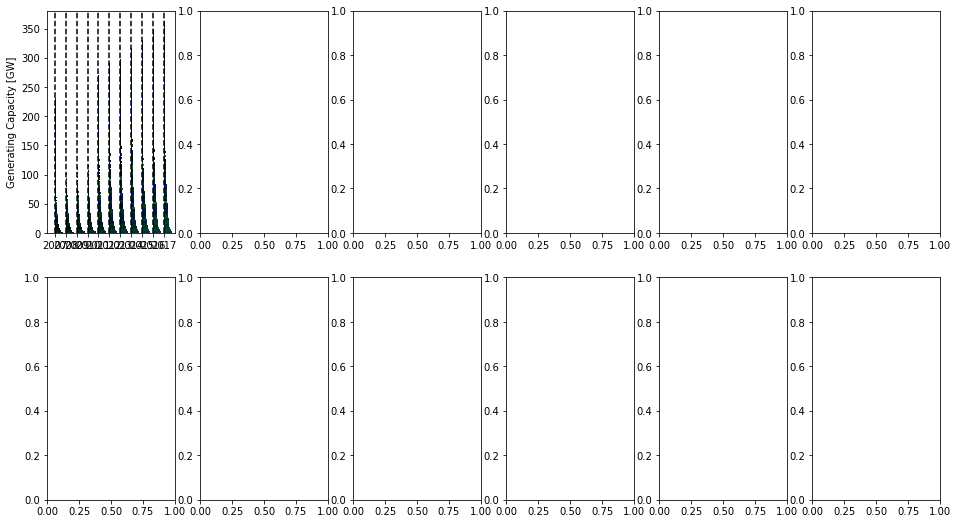

In [10]:
""" let's plot em all """
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


for r in regions:
    print r
    f, axarr = plt.subplots(1, figsize=(16,9))
    axarr.set_xlim(2006.3,2018)
    axarr.set_xticks(years)
    
    for y in years:
        
        print y
        
        sample_ff = data[y]['data_ff'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
        sample_g = data[y]['data_g'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
        sample_b = data[y]['data_b'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
        sample_all = data[y]['data_all'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T

        #"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b))
        pos = sample_all[sample_all[r]>0][[r]]
        #g = sample_g[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        #b = sample_b[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        
        pos = pos.sort_values(r, ascending=True)/1000.0
        pos['cumsum'] = pos[r].cumsum()
        pos['bin']=(pos['cumsum']/pos['cumsum'].max()*100).astype(int)

        
        #pos = pos.sort_values('cumsum', ascending=False)

        pos['g'] = sample_g[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        pos['b'] = sample_b[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        pos['color'] = pos.apply(lambda row: str_col(row['g'], row['b']), axis=1)
        #print pos
        
        down_sample = pos.groupby('bin').sum()
        down_sample['count'] = pos[['bin',r]].groupby('bin').count()
        down_sample.g = down_sample.g/down_sample['count']
        down_sample.b = down_sample.b/down_sample['count']
        down_sample['cumsum']=down_sample[r].cumsum()
        down_sample['color']=down_sample.apply(lambda row: str_col(row['g'], row['b']), axis=1)
        down_sample['log10count'] = np.log10(down_sample['count'])+np.log10(2.0)
        #print down_sample
        
        
        axarr.axvline(x=y, color='k', linestyle='--')
        """
        axarr.barh(pos['cumsum'].values-pos[r].values, #position
                   (1.0-pos['cumsum'].values/(pos['cumsum'].max())*0.9), #width
                   pos[r].values, #height
                   y,
                   align='edge',
                   color=pos.color.values)
        """
        print down_sample['log10count'].max()
        axarr.barh(down_sample['cumsum'].values-down_sample[r].values, #position
                   down_sample['log10count']/4.5, #down_sample['log10count'].max(),#(1.0-down_sample['cumsum'].values/(down_sample['cumsum'].max())*0.9), #width
                   down_sample[r].values, #height
                   y,
                   align='edge',
                   color=down_sample.color.values)
        
        
        #ariel deranger
        #raw_input('-->')
    #print pos
    axarr.set_ylabel('Generating Capacity [GW]')
    axarr.set_ylim(bottom=0.0)
    
    bottom,top = axarr.get_ylim()
    
    axarr.arrow(2007, top, .9, 0, head_width=(top-bottom)*0.03, head_length=0.1, fc='k', ec='k', width=(top-bottom)*0.01)

    axarr.text(2006.95, top+(top-bottom)*0.02,'$log_{10}(2*N_{Companies}$)')
    
    green_patch = mpatches.Patch(color='green', label='green data')
    blue_patch = mpatches.Patch(color='blue', label='blue data')
    black_patch = mpatches.Patch(color='black', label='black data')
    
    f.legend((black_patch,blue_patch,green_patch), ('Fossil Fuels','Nuclear & Large-Scale Hydro','Renewables'), loc='center', bbox_to_anchor=(0.5,0.92), ncol=3)

    f.suptitle('Cumulative Generating Capacity: '+str(r), fontsize=20)
    f.savefig('./figures/1_'+str(r)+'.png')
    plt.show()
        

In [ ]:
""" get dregree for all data"""

for y in years:
    for data_str in ['data_all','data_g','data_b', 'data_ff']:
        df = data[y][data_str]
        #degree just with connections
        df['degree'] = df[df>0].count(axis=1)
    
        #degree with algo
        #df['degree'] = df.apply(lambda row: degree(row/np.sum(row)), axis=1)
    

        cols = [c for c in list(df) if len(c)<3]
        df['sum'] = df[cols].sum(axis=1)
        df['cumsum'] = df['sum'].cumsum()
    
        data[y][data_str] = df.sort_values('sum', ascending=False)


In [ ]:
""" lets plot them degrees """
import matplotlib.patches as mpatches
import matplotlib.lines as mlines



f, axarr = plt.subplots(3,sharex=True, figsize=(16,9))
axarr[0].set_xlim(2006.3,2018)
axarr[0].set_xticks(years)
#axarr[0].set_xtickabels(years)

axarr[0].set_ylim(0,100)
axarr[1].set_ylim(0,100)
axarr[2].set_ylim(0,100)

axarr[0].arrow(2008, 100.0, .9, 0, head_width=5, head_length=0.1, fc='k', ec='k', width=2)
axarr[1].arrow(2008, 100.0, .9, 0, head_width=5, head_length=0.1, fc='k', ec='k', width=2)
axarr[2].arrow(2008, 100.0, .9, 0, head_width=5, head_length=0.1, fc='k', ec='k', width=2)

axarr[0].arrow(2006.8, 50.0, 0, -40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[1].arrow(2006.8, 50.0, 0, -40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[2].arrow(2006.8, 50.0, 0, -40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)

axarr[0].arrow(2006.8, 50.0, 0, 40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[1].arrow(2006.8, 50.0, 0, 40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[2].arrow(2006.8, 50.0, 0, 40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)

axarr[0].text(2006.7, 80,'small\ncompanies', ha='right', rotation=90)
axarr[1].text(2006.7, 80,'small\ncompanies', ha='right', rotation=90)
axarr[2].text(2006.7, 80,'small\ncompanies', ha='right', rotation=90)

axarr[0].text(2006.4, 30,'large\ncompanies', ha='left', rotation=90)
axarr[1].text(2006.4, 30,'large\ncompanies', ha='left', rotation=90)
axarr[2].text(2006.4, 30,'large\ncompanies', ha='left', rotation=90)

axarr[0].text(2007.95, 105,'d=1')
axarr[1].text(2007.95, 105,'d=1')
axarr[2].text(2007.95, 105,'d=1')

axarr[0].text(2008.95, 105,'d=5')
axarr[1].text(2008.95, 105,'d=5')
axarr[2].text(2008.95, 105,'d=5')

cols_dict={0:'black',1:'blue',2:'green'}

axarr[0].set_ylabel('%$N_{Companies, Fossil Fuel}$')
axarr[1].set_ylabel('%$N_{Companies, Nuclear & Hydro}$')
axarr[2].set_ylabel('%$N_{Companies, Renewables}$')

degree_means = []

for y in years:
    print y
    ii=0
    for data_str in ['data_ff','data_b','data_g']:
        df = data[y][data_str]
        degree_means.append(df.degree.mean())
    
        df = df.drop(df[df.degree<1.0].index)
        #print df['sum'].sum(axis=0)
        verts = np.arange(len(df))/float(len(df))*100
        degrees = ((df.degree.rolling(50, min_periods=1).mean())-1.0)/4.0#-df.degree.min())*500
        #print 'max degrees', degrees.max()*5
        #print degrees
        degrees_std = degrees+(df.degree.rolling(50, min_periods=1).std())/4.0#*500
        #print 'max std', degrees_std.max()*5
        degrees = degrees+y
        degrees_std = degrees_std+y
        #print degrees.values
    
        #print verts
        #print degrees
        #print degrees_std
        axarr[ii].plot(degrees.values,verts, color=cols_dict[ii])
        axarr[ii].fill_betweenx(verts,y,degrees_std.values, alpha=0.3, color=cols_dict[ii])
        #axarr[0].plot(degrees_std.values,verts)
        #vert = np.arange(len(df))/df['sum'].sum(axis)
    

        axarr[ii].axvline(x=y, color='k', linestyle='--')
    
        #print data[y]['data']
    
        #axarr[2].scatter(df_test['degree'],df_test['cumsum'])
        #axarr[2].violinplot(df_test['degree'],positions = [1.0], widths=50, points=10000)
        #axarr[2].set_ylabel('ALL_Cumulative_Sum')
        #f.savefig(os.path.join('output',path['ID'],'_ndwi_stats.png'))
        
        ii+=1
f.suptitle('Degree Distributions for all Companies', fontsize=20)


gray_patch = mpatches.Patch(color='gray', label='The red data')
black_line = mlines.Line2D([0],[0],color='black')

f.legend((black_line,gray_patch), ('$Rolling\_Mean_{window=50}$','$Rolling\_StdDev_{window=50}$'), loc='center', bbox_to_anchor=(0.5,0.92), ncol=2)
f.savefig('out.png')
plt.show()

print np.mean(degree_means)


In [ ]:
print data[2017]['data_all'].degree.rolling(50, min_periods=1).std().argmax()

print data[2017]['data_all'].degree.rolling(50, min_periods=1).std().to_string()

In [ ]:
print data[2017]['data_all']# - data[2017]['data_g'] - data[2017]['data_b']

In [ ]:
"""Let's do this a fan graph"""


df_all = pd.read_csv(all_MW_files[0], encoding='utf-8').set_index('COMPANY')
df_g = pd.read_csv(g_MW_files[0], encoding='utf-8').set_index('COMPANY')

df_test = pd.DataFrame(df_all.sum(axis=1).sort_values(ascending=False), columns=['sum'])
df_test['cumsum'] = df_test['sum'].cumsum()
#df_test['degree'] = df_all[df_all>0.0001].count(axis=1)
df_test['degree'] = df_all.apply(lambda row: degree(row/np.sum(row)), axis=1)

print df_test.sort_values('sum',ascending=False)
#df_test.plot('cumsum','degree')

#https://stackoverflow.com/questions/28807169/making-a-python-fan-chart-fan-plot
#https://matplotlib.org/examples/pylab_examples/boxplot_demo.html

f, axarr = plt.subplots(3, sharex=True, figsize = (16,9))
axarr[2].scatter(df_test['degree'],df_test['cumsum'])
#axarr[2].violinplot(df_test['degree'],positions = [1.0], widths=50, points=10000)
axarr[2].set_ylabel('ALL_Cumulative_Sum')
#f.savefig(os.path.join('output',path['ID'],'_ndwi_stats.png'))
plt.show()
plt.close()
plt.clf()

#print df_all.T.sum().cumsum()
#print df_g.T.sum()
#

print df_test.shape[1]
test = np.zeros((215))
test[5]=1
test[15]=1
test[24]=1
test[30]=1
print test
print 'test degree: ',degree(test.T/np.sum(test.T))


"algo degree"
#print df_all.apply(lambda row: degree(row/np.sum(row)), axis=1).plot()
#print df_g[df_g>0.0001].count(axis=1).plot()
#print df_all[df_all>0.0001].count(axis=1).plot()
#print df_all.apply() / df_all.T.max()

In [ ]:
print df_test
print df_test.degree.rolling(1000, min_periods=1).mean().plot()
print df_test.degree*100
print df_test.degree.rolling(1000, min_periods=1).std().plot()
#print len(df_test.degree.rolling(100, min_periods=1).mean().resample('1'))

In [ ]:
print (full_d_range.days)
	x_ticks = np.arange(0,full_d_range.days,365)
	print (x_ticks.shape)
	x_tick_labels = [str(i) for i in range(2008,2019)]
	print (len(x_tick_labels))
	f, axarr = plt.subplots(3, sharex=True, figsize = (16,9))
	axarr[0].scatter(x, y_area, marker='+')
	axarr[0].set_ylabel('Area [m^2]')
	axarr[0].set_xlim(0,full_d_range.days)
	axarr[0].set_xticks(x_ticks)
	axarr[0].set_xticklabels(x_tick_labels)
	axarr[0].set_title('Extents indicators for '+path['ID']+': '+path['name'])
	axarr[1].scatter(x, y_exts, marker='+')
	axarr[1].set_ylabel('Fraction')
	axarr[1].set_ylim(bottom=0.0)
	#print(y_vals)
	for y in y_vals:
		print (y.shape)
	axarr[2].violinplot(y_vals,positions = x, widths=50, points=1000)
	axarr[2].set_ylabel('values')
	f.savefig(os.path.join('output',path['ID'],'_ndwi_stats.png'))
	#plt.show()
	#plt.close()
	plt.clf()

In [ ]:
path_to_matrices = "matrix_csvs/"
years = ["2004"] + ["2007"] + [str(i) for i in range(2014,2018)] #list of all years
quarters = [".0", ".25", ".5", ".75"] #list of all quarters

In [ ]:
#Stating period for analisis
y_index = -2
q_index = 3
current_year = years[y_index] + quarters[q_index] #The year and quarter we will do the analisis for

#Importing the files needed
df_all = pd.read_csv(path_to_matrices + current_year + "_all_projection.csv")
names = list(df_all.columns[1:]) #Getting names of nodes
n_countries = len(names)
ADJ_all = np.loadtxt(open(path_to_matrices + current_year + "_all_projection.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) #getting the adjacency matrix
#files are empty
#pd.read_csv(path_to_matrices + current_year + "_blue_projection.csv")
#Adjmat_blue = np.loadtxt(open(path_to_matrices + current_year + "_blue_projection.csv", "rb"), delimiter=",", skiprows=1, 
           #usecols=range(1,n_countries+1)) #getting the adjacency matrix
#Adjmat_green = np.loadtxt(open(path_to_matrices + current_year + "_green_projection.csv", "rb"), delimiter=",", skiprows=1, 
           #usecols=range(1,n_countries+1)) #getting the adjacency matrix

Note, in year 2004 there is hardly little influence between countries. In year 2017 there is more, although still not a lot (think?)

In [ ]:
print(np.diagonal(ADJ_all)) #Is this correct? A "1" in the diagonal would indicate the country is not influenced
#by any other country?
plt.imshow(ADJ_all) #Few influence between countries?
plt.colorbar()

In [ ]:
#This is an isolated node.
ADJ_all[0]

In [ ]:
#Only small countries can be influenced?
print("Small diagonal value")
for i in range(n_countries):
    if np.diagonal(ADJ_all)[i] < 0.5:
        print i, " ", names[i]

In [ ]:
#PageRank centrality with igraph
G_all =  igraph.Graph.Weighted_Adjacency(ADJ_all.tolist() ,mode="directed")
pr_all = G_all.personalized_pagerank(weights=G_all.es["weight"], directed=True)
names_copy = copy.copy(names)
inds = np.array(pr_all).argsort()[::-1][:]
sort_names_pr = np.array(names_copy)[inds]
sort_centrality_pr = np.array(pr_all)[inds]
sort_names_pr, sort_centrality_pr
plt.plot(pr_all, "o")

### Loading matrices and making projections

In [ ]:
#Extracting bipartite adj mat
ADJ_bip_green = np.loadtxt(open(path_to_matrices + current_year + "_green_MW.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) #getting the adjacency matrix
ADJ_bip_blue = np.loadtxt(open(path_to_matrices + current_year + "_blue_MW.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) #getting the adjacency matrix
#Does the all category include the green and blue or is it just the dirty ones? In principle we would like to have 
#only the dirty ones, right?
ADJ_bip_all = np.loadtxt(open(path_to_matrices + current_year + "_all_MW.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) 
#To get the high emission plants we use the all matrix and remove the "clean" part
ADJ_bip_dirty = ADJ_bip_all - (ADJ_bip_green + ADJ_bip_blue)


#Making the company projection
ADJ_comp_green =  (ADJ_bip_green/ADJ_bip_green.sum()).dot(ADJ_bip_green.T/(ADJ_bip_green.T.sum()))
ADJ_comp_blue =  (ADJ_bip_blue/ADJ_bip_blue.sum()).dot(ADJ_bip_blue.T/(ADJ_bip_blue.T.sum()))
ADJ_comp_all =  (ADJ_bip_all/ADJ_bip_all.sum()).dot(ADJ_bip_all.T/(ADJ_bip_all.T.sum()))
ADJ_comp_dirty =  (ADJ_bip_dirty /ADJ_bip_dirty .sum()).dot(ADJ_bip_dirty.T/(ADJ_bip_dirty .T.sum()))
#Making the country projection
ADJ_country_green =  (ADJ_bip_green.T/ADJ_bip_green.T.sum()).dot(ADJ_bip_green/(ADJ_bip_green.sum()))
ADJ_country_blue =  (ADJ_bip_blue.T/ADJ_bip_blue.T.sum()).dot(ADJ_bip_blue/(ADJ_bip_blue.sum()))
ADJ_country_all =  (ADJ_bip_all.T/ADJ_bip_all.T.sum()).dot(ADJ_bip_all/(ADJ_bip_all.sum()))
ADJ_country_dirty =  (ADJ_bip_dirty.T /ADJ_bip_dirty.T .sum()).dot(ADJ_bip_dirty/(ADJ_bip_dirty.sum()))

#Getting the percentage of emissions of each type for each country
green_part = [sum(ADJ_bip_green[:, i])/sum(ADJ_bip_all[:, i]) for i in range(n_countries)]
blue_part = [sum(ADJ_bip_blue[:, i])/sum(ADJ_bip_all[:, i]) for i in range(n_countries)]
dirty_part = [sum(ADJ_bip_dirty[:, i])/sum(ADJ_bip_all[:, i]) for i in range(n_countries)]

# Multilayer analysis

In [ ]:

def make_supra_adj(ADJ_list, COUP_list):
    """Function that takes list of adj matrix and coupling and generates the supra adjacency matrix of the
    multiplex network
    Args:
        ADJ_list: list of numpy 2D array's. Each of them is an adjacency matrix
        COUP_list: list of numpy 1D array's. Each of them is the vector to be used for coupling the matrices
    Return:
        Supra Adjacency matrix. Numpy 2D array.
    """
    n_layers = len(ADJ_list)
    n_nodes = ADJ_list[0].shape[0]
    
    #stacking up adjacency matrix and coupling accordingly
    sup_list = []
    for i in range(n_layers):
        row = []
        for j in range(n_layers):
            if i == j: #if in diagonal add adjacency matrix
                row.append(ADJ_list[i])
                #print(ADJ_list[i].shape)
            else: #otherwise add the coupling (diagonal since multiplex network)
                row.append(np.diag(COUP_list[i])) #if i or j here defined direction of coupling
                #print(np.diag(COUP_list[i]).shape)
        sup_list.append(row)
        
    return np.bmat(sup_list)
    
n_nodes = n_countries
n_layers = 3
#The following function is taylored for igraph centrality
def flatten_centrality(centrality_vector, n=n_nodes, l=n_layers, names=names, hubauth=False):
    '''Centrality networks in a Multiplex are commonly expressed as a vector of
    nlx1 dimension. To have a centrality for each node it is important to flatten
    the vector into nx1 dimension. Also, it is important return a list of ranked
    nodes and another of their score.
    Args
    centrality_vector(numpy array): the centrality measure for each node-layer
    n(int): number of nodes
    l(int): number of layers
    names(list of strings): name of nodes (countries)
    hubauth(boolean): indicating if the centrality is hub or authority
    Return:
    sort_names_multi(list of strings): names of countries ordered by centrality
    sort_centrality_multi(list of flots): sorted score of nodes
    '''
    multi_centrality = []
    for i in range(n):
        cent = 0
        for k in range(l):
            cent += centrality_vector[i + n*k]
        if hubauth:
            multi_centrality.append(cent[0])
        else:
            multi_centrality.append(cent)
    node_names = np.array(copy.deepcopy(names))
    inds = np.array(multi_centrality).argsort()[::-1][:]
    sort_names_multi = node_names[inds]
    sort_centrality_multi = np.array(multi_centrality)[inds]
    
    return sort_names_multi, sort_centrality_multi    


In [ ]:
#Making the supra adjacency matrix
SUPADJ_country = make_supra_adj([ADJ_country_green, ADJ_country_blue, ADJ_country_dirty], [green_part, blue_part, dirty_part]) 

In [ ]:
#making the graph
G_supra = igraph.Graph.Weighted_Adjacency( SUPADJ_country.tolist() ,mode="directed") 
#computing pagerank
pr_muliplex = G_supra.personalized_pagerank(weights=G_supra.es["weight"])
#sorting it appropriately
pr_multiplex_sorted = flatten_centrality(pr_muliplex)

In [ ]:
pr_multiplex_sorted

Comparing it with the aggregate pagerank centrality

In [ ]:
G_all =  igraph.Graph.Weighted_Adjacency( ADJ_all.tolist() ,mode="directed")
pr_all = G_all.personalized_pagerank(weights=G_all.es["weight"])
names_copy = copy.copy(names)
inds = np.array(pr_all).argsort()[:]
#If small countries are first, try including the [::-1 as below]
#inds = np.array(pr_all).argsort()[::-1][:]
sort_names_pr = np.array(names_copy)[inds]
sort_centrality_pr = np.array(pr_all)[inds]

In [ ]:
sort_names_pr, sort_centrality_pr

# Inconsistency between networkx and igraph?
I tend to trust igraph more, however the discrepancy might mean that values in general are too close. Perhaps networkx power method is not converging?

In [ ]:
#PageRank centrality with igraph
G_all =  igraph.Graph.Weighted_Adjacency(ADJ_all.tolist() ,mode="directed")
pr_all = G_all.personalized_pagerank(weights=G_all.es["weight"], directed=True)
names_copy = copy.copy(names)
#inds = np.array(pr_all).argsort()[::-1][:]
inds = np.array(pr_all).argsort()[:]
sort_names_pr = np.array(names_copy)[inds]
sort_centrality_pr = np.array(pr_all)[inds]
sort_names_pr, sort_centrality_pr

#PageRank centrality with networkx
G_all_nx = nx.from_numpy_matrix(ADJ_all)
pr_all_nx = nx.pagerank(G_all_nx, weight="weight")
plt.plot(pr_all_nx.values(), "o")
plt.plot(pr_all, ".")

In [ ]:
plt.plot(pr_all, pr_all_nx.values(), "o")

In [ ]:
for i in range(n_countries):
    print i, "nx = ", names[sorted(pr_all_nx.items(), key=lambda x:x[1])[::-1][i][0]], "ig = ", sort_names_pr[i]

In [ ]:
#If we want to do Hubs and Auth the following code will be usefull
"""def G_list_hub(G_adj_list):
    '''
    Args(list): list of graphs adjacency matrices
    Return(list): list of adjacency matrices to be used in the block diagonal
    of the supra adjacency matrix for hub score
    '''
    G_hub = []
    for g in G_adj_list:
        new = np.dot(g, g.transpose())
        G_hub.append(new)
    return G_hub

def G_list_auth(G_adj_list):
    '''
    Args(list): list of graphs adjacency matrices
    Return(list): list of adjacency matrices to be used in the block diagonal
    of the supra adjacency matrix for auth score
    '''
    G_auth = []
    for g in G_adj_list:
        new = np.dot( g.transpose(), g)
        G_auth.append(new)
    return G_auth

def hub_auth_diag(Coup_list):
    coup = []
    for c in Coup_list:
        coup.append(c*c)
    return coup"""


In [ ]:
pd.__version__
